# Introduction to Stat Arb
This notebook covers my initial learnings for implementing statistical arbitrage strategies in crypto. We will be using two assets- ETH and SOL.

## Setup- Retrieving data etc

In [3]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [4]:
# --- CONFIGURATION ---
EXCHANGE_ID = 'binance'
SYMBOL_1 = 'ETH/USDT'
SYMBOL_2 = 'SOL/USDT'
TIMEFRAME = '1h'
LIMIT = 1000  # Number of data points (e.g., 1000 hours)

In [5]:
# Initialize Exchange
exchange = ccxt.binance()

In [6]:
def fetch_data(symbol, timeframe, limit):
    """Fetches OHLCV data and returns a DataFrame of closing prices."""
    print(f"Fetching {symbol} data...")
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df['close']

In [7]:
eth_prices = fetch_data(SYMBOL_1, TIMEFRAME, LIMIT)
sol_prices = fetch_data(SYMBOL_2, TIMEFRAME, LIMIT)

Fetching ETH/USDT data...
Fetching SOL/USDT data...


In [8]:
eth_prices, sol_prices

(timestamp
 2025-09-13 22:00:00    4658.53
 2025-09-13 23:00:00    4666.53
 2025-09-14 00:00:00    4670.27
 2025-09-14 01:00:00    4673.13
 2025-09-14 02:00:00    4683.16
                         ...   
 2025-10-25 09:00:00    3942.49
 2025-10-25 10:00:00    3942.56
 2025-10-25 11:00:00    3940.31
 2025-10-25 12:00:00    3953.37
 2025-10-25 13:00:00    3936.49
 Name: close, Length: 1000, dtype: float64,
 timestamp
 2025-09-13 22:00:00    241.89
 2025-09-13 23:00:00    242.38
 2025-09-14 00:00:00    243.50
 2025-09-14 01:00:00    245.79
 2025-09-14 02:00:00    248.68
                         ...  
 2025-10-25 09:00:00    192.58
 2025-10-25 10:00:00    192.00
 2025-10-25 11:00:00    192.71
 2025-10-25 12:00:00    193.91
 2025-10-25 13:00:00    192.78
 Name: close, Length: 1000, dtype: float64)

In [9]:
# Combine and align data (important as timestamps might slightly differ)
data = pd.concat([eth_prices, sol_prices], axis=1).dropna()
data.columns = ['ETH_Price', 'SOL_Price']
data

,ETH_Price,SOL_Price
timestamp,,
2025-09-13 22:00:00,4658.53,241.89
2025-09-13 23:00:00,4666.53,242.38
2025-09-14 00:00:00,4670.27,243.50
2025-09-14 01:00:00,4673.13,245.79
2025-09-14 02:00:00,4683.16,248.68
...,...,...
2025-10-25 09:00:00,3942.49,192.58
2025-10-25 10:00:00,3942.56,192.00
2025-10-25 11:00:00,3940.31,192.71


In [10]:
# --- STEP 2: Creating the Stat Arb Spread (Log Ratio) ---
# Use log prices to standardize the volatility of returns
data['Log_ETH'] = np.log(data['ETH_Price'])
data['Log_SOL'] = np.log(data['SOL_Price'])
data

,ETH_Price,SOL_Price,Log_ETH,Log_SOL
timestamp,,,,
2025-09-13 22:00:00,4658.53,241.89,8.446455,5.488483
2025-09-13 23:00:00,4666.53,242.38,8.448171,5.490507
2025-09-14 00:00:00,4670.27,243.50,8.448972,5.495117
2025-09-14 01:00:00,4673.13,245.79,8.449584,5.504478
2025-09-14 02:00:00,4683.16,248.68,8.451728,5.516167
...,...,...,...,...
2025-10-25 09:00:00,3942.49,192.58,8.279568,5.260512
2025-10-25 10:00:00,3942.56,192.00,8.279586,5.257495
2025-10-25 11:00:00,3940.31,192.71,8.279015,5.261186


In [11]:
# The Spread (Log ratio) is the difference between log prices
# This assumes an ideal hedging ratio of 1:1, a simplification for this demo.
data['Spread'] = data['Log_ETH'] - data['Log_SOL']
data

,ETH_Price,SOL_Price,Log_ETH,Log_SOL,Spread
timestamp,,,,,
2025-09-13 22:00:00,4658.53,241.89,8.446455,5.488483,2.957972
2025-09-13 23:00:00,4666.53,242.38,8.448171,5.490507,2.957664
2025-09-14 00:00:00,4670.27,243.50,8.448972,5.495117,2.953855
2025-09-14 01:00:00,4673.13,245.79,8.449584,5.504478,2.945107
2025-09-14 02:00:00,4683.16,248.68,8.451728,5.516167,2.935561
...,...,...,...,...,...
2025-10-25 09:00:00,3942.49,192.58,8.279568,5.260512,3.019056
2025-10-25 10:00:00,3942.56,192.00,8.279586,5.257495,3.022090
2025-10-25 11:00:00,3940.31,192.71,8.279015,5.261186,3.017828


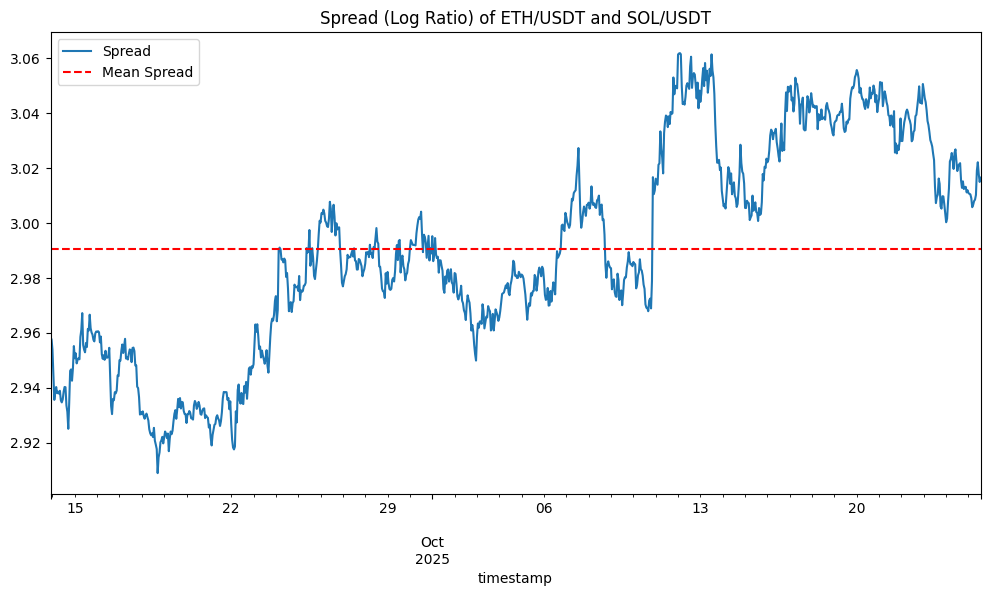

In [12]:
# Plot the Spread to visually inspect for mean reversion
plt.figure(figsize=(12, 6))
data['Spread'].plot(title=f'Spread (Log Ratio) of {SYMBOL_1} and {SYMBOL_2}')
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()

## Diagnosing and Achieving Stationarity
For statistical arbitrage strategies to work, we need stationarity between the spread of two assets. We need to confirm that the spread is stationary using the Augmented Dickey-Fuller test.

In [13]:
def run_adf_test(series, series_name):
    """Performs the Augmented Dickey-Fuller Test."""
    print("-" * 50)
    print(f"Augmented Dickey-Fuller Test for: {series_name}")
    
    # Run the test
    result = adfuller(series.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    # Decision Logic
    if result[1] <= 0.05 and result[0] < result[4]['5%']:
        print("\nConclusion: REJECT the Null Hypothesis (Unit Root).")
        print(f"The series ({series_name}) IS LIKELY STATIONARY (mean-reverting).")
    else:
        print("\nConclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).")
        print(f"The series ({series_name}) IS LIKELY NON-STATIONARY (trending).")
    print("-" * 50)

In [14]:
# 1. Test the raw asset (Should be NON-STATIONARY)
run_adf_test(data['Log_ETH'], f'Log Price of {SYMBOL_1}')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Log Price of ETH/USDT
ADF Statistic: -1.8368
p-value: 0.3624
Critical Values:
	1%: -3.4369
	5%: -2.8644
	10%: -2.5683

Conclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).
The series (Log Price of ETH/USDT) IS LIKELY NON-STATIONARY (trending).
--------------------------------------------------


In [ ]:
# 2. Test the Spread (This MUST be STATIONARY for Stat Arb)
run_adf_test(data['Spread'], 'Pair Spread')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Pair Spread
ADF Statistic: -1.8148
p-value: 0.3731
Critical Values:
	1%: -3.4369
	5%: -2.8644
	10%: -2.5683

Conclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).
The series (Pair Spread) IS LIKELY NON-STATIONARY (trending).
--------------------------------------------------


We see that ETH and SOL are likely to be highly correlated, which do not lend them to stat arb. For the purpose of completing this analysis, we will compute their autocorrelation.

## Autocorrelation
Autocorrelation is the measure of how much we can predict the mean reverting property between two assets. We need the autocorrelation to be both predictable and fast, so I believe the sweet spot is usually around 0.5.

We will use:
- Autocorrelation function: measures the correlation between the time series and past values. In an ideal AR(1) spread, we want the autocorrelation to be strong at time lag 1, and it should exponentially decay for longer time spreads.
- Partial autocorrelation function: it measures the autocorrelation between two point in time after removing the linear effects of the values in between. 

We use both measures to see if the autocorrelation occurs at the time lag that we are interested in.

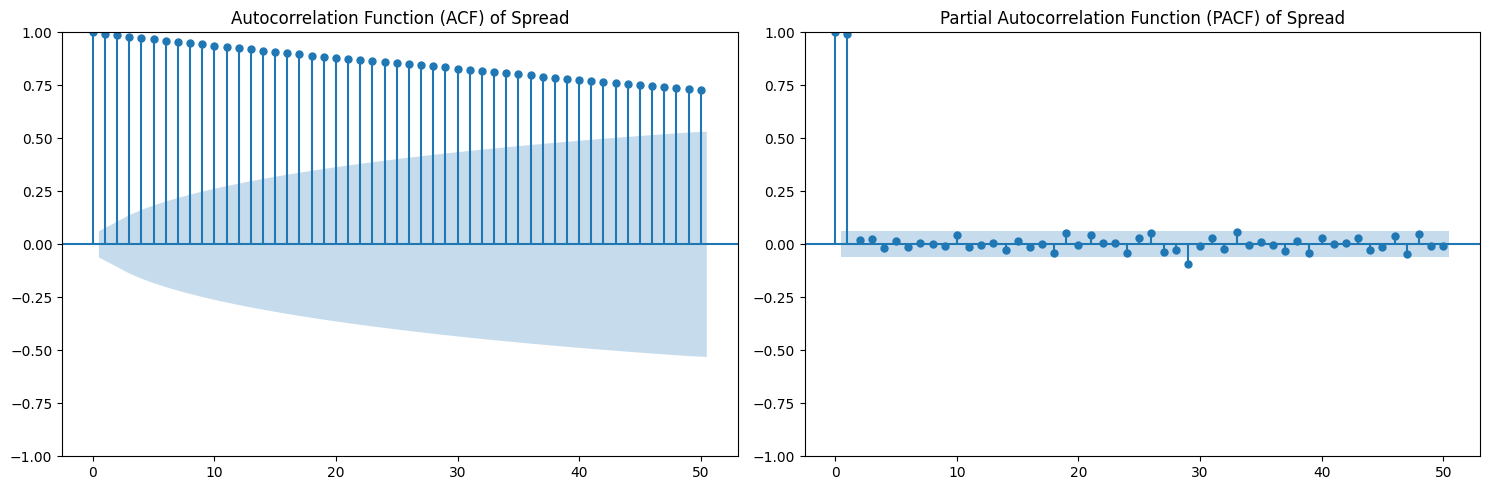

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF: Shows correlation with past values (direct and indirect effects)
plot_acf(data['Spread'].dropna(), lags=50, ax=axes[0], title='Autocorrelation Function (ACF) of Spread')

# PACF: Shows correlation with past values (direct effect only)
plot_pacf(data['Spread'].dropna(), lags=50, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Spread')

plt.tight_layout()
plt.show()

These ACF and PACF plots confirm that the spread between ETH and SOL are non-stationary:
- ACF: it should exponentially decay post 1 time period, but this is not the case
- PACF: a single dominant spike at lag 1, then drop off to close to 0 for subsequent lags. While this is what we want, unfortunately we cannot analyse PACF in isolation. Instead, we need to first confirm with ACF.

## Refactor code into reusable functions

In [18]:
def generate_spread_df(asset_one, asset_two, asset_one_price, asset_two_price):
    data = pd.concat([asset_one_price, asset_two_price], axis=1).dropna()
    data.columns = [f'{asset_one}_Price', f'{asset_two}_Price']

    data[f'Log_{asset_one}'] = np.log(data[f'{asset_one}_Price'])
    data[f'Log_{asset_two}'] = np.log(data[f'{asset_two}_Price'])

    data['Spread'] = data[f'Log_{asset_one}'] - data[f'Log_{asset_two}']

    return data

In [23]:
def plot_autocorrelation(data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # ACF: Shows correlation with past values (direct and indirect effects)
    plot_acf(data['Spread'].dropna(), lags=50, ax=axes[0], title='Autocorrelation Function (ACF) of Spread')

    # PACF: Shows correlation with past values (direct effect only)
    plot_pacf(data['Spread'].dropna(), lags=50, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Spread')

    plt.tight_layout()
    plt.show()

## Wrapped tokens
While ETH/SOL pair is non-stationary, we will investigate wrapped tokens, specifically WBTC/BTC and WSTETH/ETH.

### WBTC/BTC

In [17]:
btc_prices = fetch_data('BTC/USDT', TIMEFRAME, LIMIT)
wbtc_prices = fetch_data('WBTC/USDT', TIMEFRAME, LIMIT)
btc_prices, wbtc_prices

Fetching BTC/USDT data...
Fetching WBTC/USDT data...


(timestamp
 2025-09-14 12:00:00    115776.31
 2025-09-14 13:00:00    115348.10
 2025-09-14 14:00:00    115401.75
 2025-09-14 15:00:00    115224.01
 2025-09-14 16:00:00    115480.00
                          ...    
 2025-10-25 23:00:00    111646.27
 2025-10-26 00:00:00    111715.98
 2025-10-26 01:00:00    111644.42
 2025-10-26 02:00:00    111448.85
 2025-10-26 03:00:00    111460.77
 Name: close, Length: 1000, dtype: float64,
 timestamp
 2025-09-14 12:00:00    115753.58
 2025-09-14 13:00:00    115322.54
 2025-09-14 14:00:00    115368.48
 2025-09-14 15:00:00    115235.62
 2025-09-14 16:00:00    115473.78
                          ...    
 2025-10-25 23:00:00    111623.30
 2025-10-26 00:00:00    111723.58
 2025-10-26 01:00:00    111638.79
 2025-10-26 02:00:00    111429.86
 2025-10-26 03:00:00    111469.74
 Name: close, Length: 1000, dtype: float64)

In [19]:
btc_wbtc_spread_df = generate_spread_df("BTC", "WBTC", btc_prices, wbtc_prices)
btc_wbtc_spread_df

,BTC_Price,WBTC_Price,Log_BTC,Log_WBTC,Spread
timestamp,,,,,
2025-09-14 12:00:00,115776.31,115753.58,11.659415,11.659219,0.000196
2025-09-14 13:00:00,115348.10,115322.54,11.655710,11.655488,0.000222
2025-09-14 14:00:00,115401.75,115368.48,11.656175,11.655886,0.000288
2025-09-14 15:00:00,115224.01,115235.62,11.654633,11.654734,-0.000101
2025-09-14 16:00:00,115480.00,115473.78,11.656853,11.656799,0.000054
...,...,...,...,...,...
2025-10-25 23:00:00,111646.27,111623.30,11.623091,11.622885,0.000206
2025-10-26 00:00:00,111715.98,111723.58,11.623715,11.623783,-0.000068
2025-10-26 01:00:00,111644.42,111638.79,11.623074,11.623024,0.000050


In [21]:
run_adf_test(btc_wbtc_spread_df['Log_BTC'], f'Log Price of BTC')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Log Price of BTC
ADF Statistic: -1.6059
p-value: 0.4806
Critical Values:
	1%: -3.4369
	5%: -2.8644
	10%: -2.5683

Conclusion: FAIL TO REJECT the Null Hypothesis (Unit Root).
The series (Log Price of BTC) IS LIKELY NON-STATIONARY (trending).
--------------------------------------------------


In [20]:
run_adf_test(btc_wbtc_spread_df['Spread'], 'Pair Spread')

--------------------------------------------------
Augmented Dickey-Fuller Test for: Pair Spread
ADF Statistic: -3.8009
p-value: 0.0029
Critical Values:
	1%: -3.4370
	5%: -2.8645
	10%: -2.5683

Conclusion: REJECT the Null Hypothesis (Unit Root).
The series (Pair Spread) IS LIKELY STATIONARY (mean-reverting).
--------------------------------------------------


Interesting! It seems like BTC/WBTC pair could be stationary. Let's do further tests.

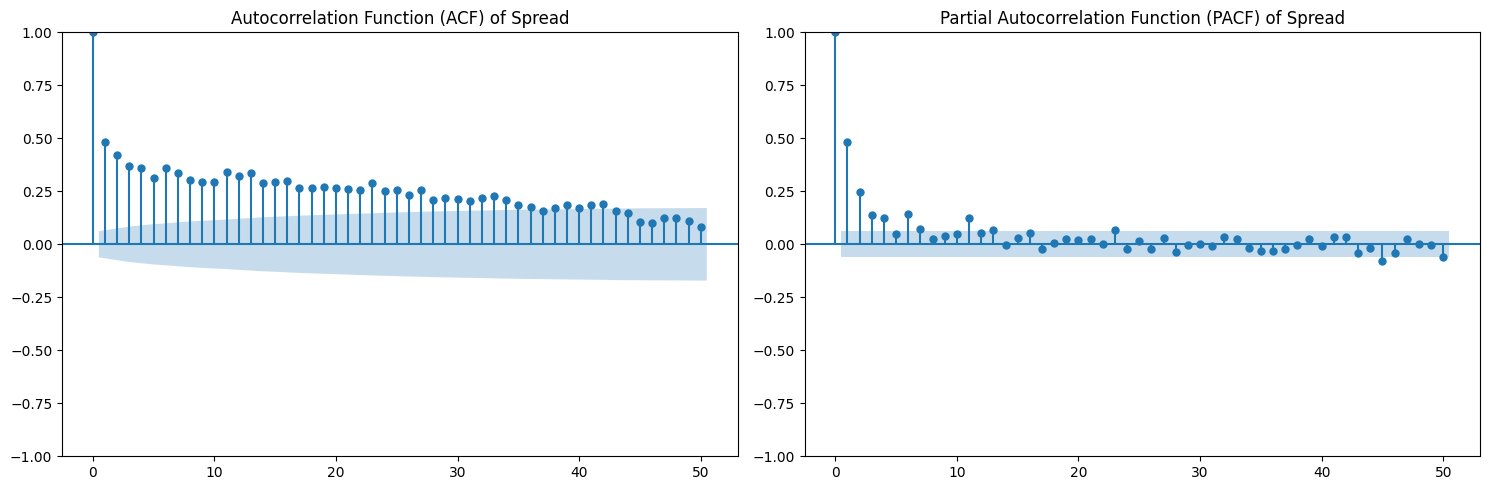

In [24]:
plot_autocorrelation(btc_wbtc_spread_df)

Well this is promising! We have a low ADF value, along with exponential decay in ACF. Our PACF plot shows the potential to fit an autoregressive model of order 4. 

## Implement ARMA(4) model
We will implement the Autoregressive Moving Average (ARMA) model as the time series that we see is stationary. ARMA models the series past values (AR) and pass errors (MA).

We use a value of 4 for `p` as it is the number of spikes in our PACF model before the cut-off, and 0 for `q` as our ACF plot decayed slowly, which suggests that past forecast errors are not useful for predicting the current spread value. Lastly, we use a value of 0 for `d`, as our current plot already suggests that our data is stationary.


In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
p, d, q = 4, 0, 0
order = (p, d, q)

In [28]:
model = ARIMA(btc_wbtc_spread_df['Spread'], order=order)
model_fit = model.fit()
print("\nModel Summary:")
print(model_fit.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 Spread   No. Observations:                 1000
Model:                 ARIMA(4, 0, 0)   Log Likelihood                6596.193
Date:                Sun, 26 Oct 2025   AIC                         -13180.386
Time:                        12:04:02   BIC                         -13150.939
Sample:                    09-14-2025   HQIC                        -13169.194
                         - 10-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.832e-05   3.66e-05     -0.774      0.439      -0.000    4.34e-05
ar.L1          0.3121      0.013     23.134      0.000       0.286       0.339
ar.L2          0.1700      0.016    

### Plot the actual vs fitted value

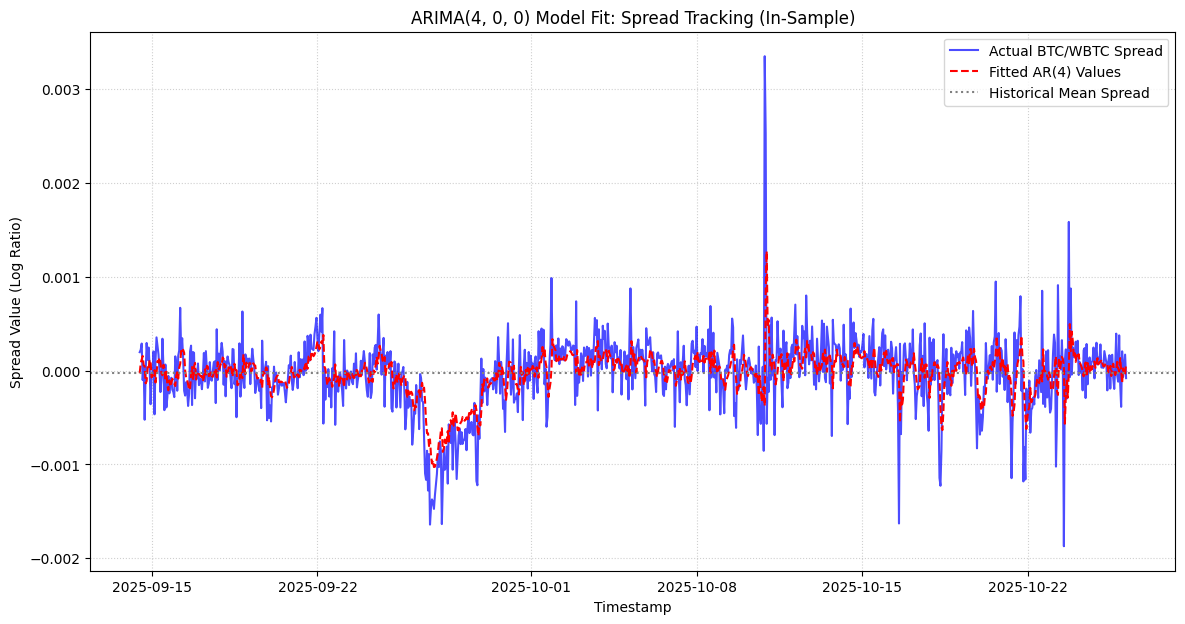

In [31]:
plt.figure(figsize=(14, 7))

# Plot the original spread time series
plt.plot(btc_wbtc_spread_df['Spread'], label='Actual BTC/WBTC Spread', color='blue', alpha=0.7)

# Plot the fitted (in-sample predicted) values
fitted_values = model_fit.fittedvalues
plt.plot(fitted_values, label=f'Fitted AR({p}) Values', color='red', linestyle='--')

# Plot the mean spread for context (Mean Reversion Level)
mean_spread = btc_wbtc_spread_df['Spread'].mean()
plt.axhline(mean_spread, color='gray', linestyle=':', label='Historical Mean Spread')

plt.title(f'ARIMA{order} Model Fit: Spread Tracking (In-Sample)')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value (Log Ratio)')
plt.legend()
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.show()

The AR(4) structure tracks the actual spread extremely closely. There is also strong mean reversion, as highlighted by how the blue line is centered around 0.

### Plot the forecast (Trading Signal)

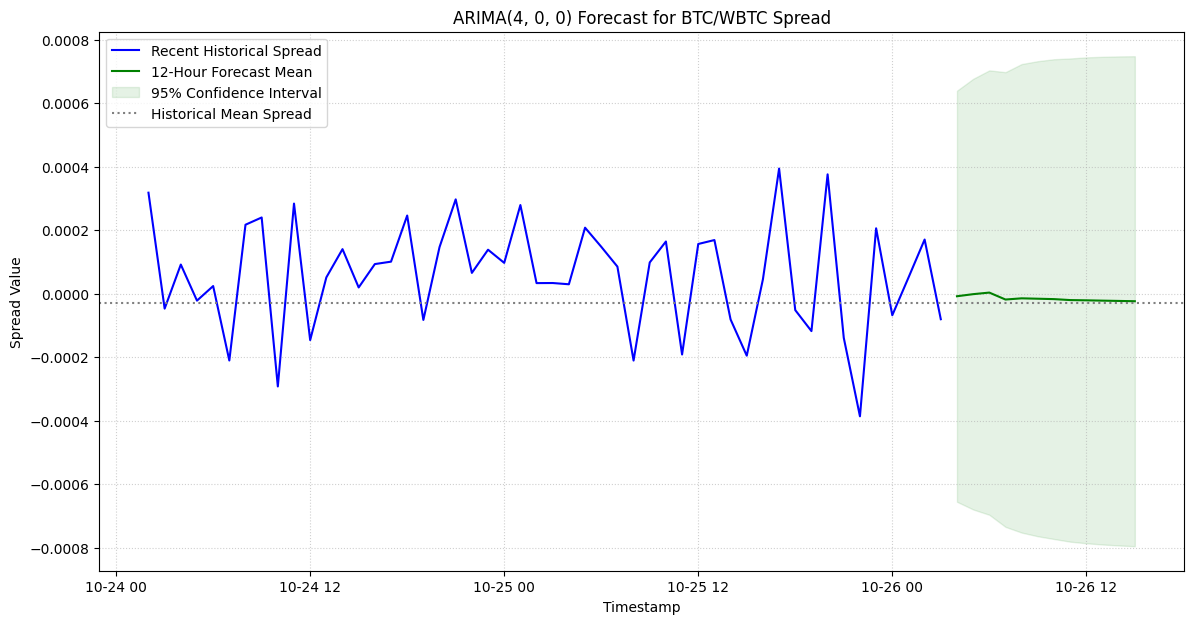

In [33]:
# We forecast the next 12 hours (since you use 1h data)
forecast_steps = 12
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int() # 95% confidence interval

plt.figure(figsize=(14, 7))

# Plot the recent history (e.g., last 50 data points)
recent_history_length = 50
plt.plot(btc_wbtc_spread_df['Spread'][-recent_history_length:], label='Recent Historical Spread', color='blue')

# Plot the forecast
plt.plot(forecast_mean, label='12-Hour Forecast Mean', color='green', linestyle='-')

# Plot the confidence interval (critical for risk management)
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.1, label='95% Confidence Interval')

plt.axhline(mean_spread, color='gray', linestyle=':', label='Historical Mean Spread')

plt.title(f'ARIMA{order} Forecast for BTC/WBTC Spread')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.show()

While mean reversion dominates the forecast, volatility is extremely low and reversion is fast- this suggests that any profit generated will likely be entirely consumed by trading fees. If we were to implement this strategy well, we will need ultra low latency and fees.

## Test the residuals of the model for ARCH/GARCH effects,
We will conduct Ljung-Box test on the squared residuals to confirm that the errors are heteroskedastic. If not, then we will need to employ GARCH modelling.

In [34]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [35]:
time_series = btc_wbtc_spread_df['Spread']

In [36]:
residuals = model_fit.resid

In [37]:
# ARCH-LM Test is the formal test, but Ljung-Box on squared residuals is a good proxy.
# We test up to 20 lags.
ljung_box_results = acorr_ljungbox(residuals**2, lags=20, return_df=True)

In [38]:
print("\nLjung-Box Test on Squared AR(4) Residuals:")
print(ljung_box_results.head())


Ljung-Box Test on Squared AR(4) Residuals:
     lb_stat     lb_pvalue
1  52.767252  3.755104e-13
2  94.640686  2.812134e-21
3  95.212797  1.661816e-20
4  96.139084  6.523417e-20
5  97.760108  1.566684e-19


In [39]:
# Determine if GARCH effects are present
if (ljung_box_results['lb_pvalue'] < 0.05).any():
    print("\nCONCLUSION: Significant GARCH effects detected (p-values < 0.05).")
    print("Proceeding to Step 3: Joint AR(4)-GARCH modeling is necessary.")
else:
    print("\nCONCLUSION: No significant GARCH effects detected.")
    print("The simple AR(4) model may be sufficient.")


CONCLUSION: Significant GARCH effects detected (p-values < 0.05).
Proceeding to Step 3: Joint AR(4)-GARCH modeling is necessary.


The low p-values suggest that volatility clustering is present. We will need to model them.

## GARCH
We will proceed with doing a joint estimation using an autoregressive with GARCH model. This ensures that parameters for mean reversion and volatility persistence are estimated optimally together.

In [41]:
import arch 

In [ ]:
# We use the 'arch_model' from the ARCH library for this joint estimation.
# Mean model: 'ar' (Autoregressive) with order 'p'=4
# Volatility model: 'Garch' (GARCH) with p=1 and q=1
# Distribution: 't' is often preferred for financial data over 'normal' due to heavy tails.

# Note: The 'arch' package syntax uses p/q for GARCH orders, and the AR order 
# is specified in the mean model argument.

# --- Prepare Mean Model Arguments ---
# The mean model arguments for arch.arch_model are the time series itself,
# and the specification of the AR component.
am = arch.arch_model(
    time_series, 
    mean='AR', # Specify Autoregressive mean model
    lags=4,    # Order of AR (p=4)
    vol='Garch', # Specify GARCH volatility model
    p=1, q=1,    # GARCH orders (GARCH(1,1))- default setting, usually good
    dist='t'     # Use Student's t-distribution for errors
)


In [43]:
# Fit the joint model
garch_fit = am.fit(disp='off')
print("\n" * 2)
print("----------------------------------------------------------")
print("STEP 3: AR(4)-GARCH(1,1) Joint Model Summary")
print("----------------------------------------------------------")
print(garch_fit.summary())




----------------------------------------------------------
STEP 3: AR(4)-GARCH(1,1) Joint Model Summary
----------------------------------------------------------
                              AR - GARCH Model Results                              
Dep. Variable:                       Spread   R-squared:                       0.304
Mean Model:                              AR   Adj. R-squared:                  0.301
Vol Model:                            GARCH   Log-Likelihood:                6737.81
Distribution:      Standardized Student's t   AIC:                          -13457.6
Method:                  Maximum Likelihood   BIC:                          -13413.5
                                              No. Observations:                  996
Date:                      Sun, Oct 26 2025   Df Residuals:                      991
Time:                              12:31:58   Df Model:                            5
                                  Mean Model                         

/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_72934/1610514788.py:2: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  garch_fit = am.fit(disp='off')


We see that there is optimisation failure. Let's try to solve them.

In [46]:
fitting_attempts = [
    # Attempt 1: Default solver (SLSQP), increased iterations
    {'disp': 'off', 'options': {'maxiter': 50, 'ftol': 1e-06}}, 
    
    # Attempt 2: Use Powell optimizer (requires placing 'optimizer' in options)
    {'disp': 'off', 'options': {'optimizer': 'powell', 'maxiter': 100}},
    
    # Attempt 3: Try tighter tolerance with default solver
    {'disp': 'off', 'options': {'maxiter': 100, 'ftol': 1e-08}} 
]


In [47]:
success = False
for i, config in enumerate(fitting_attempts):
    # Separate the general arguments (like 'disp') from the 'options' dict
    options = config.pop('options', {}) 
    disp = config.pop('disp', 'off') # Get disp, default to 'off'

    print(f"Attempt {i+1}: Fitting model with options {options}...")
    try:
        # Fit the model, passing optimization options via the 'options' argument
        garch_fit = am.fit(disp=disp, **config, options=options)
        
        # Check convergence status (Status 0 usually means successful convergence)
        if garch_fit.optimization_result.status == 0:
            success = True
            print(f"Attempt {i+1} converged successfully (Status 0).")
            break
        else:
            print(f"Attempt {i+1} finished but failed to converge completely. Status: {garch_fit.optimization_result.status}")
            
    except Exception as e:
        print(f"Attempt {i+1} failed due to internal error: {e}")


Attempt 1: Fitting model with options {'maxiter': 50, 'ftol': 1e-06}...
Attempt 1 finished but failed to converge completely. Status: 4
Attempt 2: Fitting model with options {'optimizer': 'powell', 'maxiter': 100}...
Attempt 2 finished but failed to converge completely. Status: 4
Attempt 3: Fitting model with options {'maxiter': 100, 'ftol': 1e-08}...
Attempt 3 finished but failed to converge completely. Status: 4


/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_72934/3015565207.py:10: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  garch_fit = am.fit(disp=disp, **config, options=options)
/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_72934/3015565207.py:10: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  garch_fit = am.fit(disp=disp, **config, options=options)
/var/folders/mk/spx5m7bs31zcl288wyr4sdfm0000gn/T/ipykernel_72934/3015565207.py:10: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  garch_fit = am.fit(disp=disp, **config, options=options)


In [48]:
if success:
    print("\n" * 2)
    print("----------------------------------------------------------")
    print("STEP 3: AR(4)-GARCH(1,1) Joint Model Summary (Successful Fit)")
    print("----------------------------------------------------------")
    print(garch_fit.summary())
    
else:
    print("\n----------------------------------------------------------")
    print("FATAL: All optimization attempts failed to converge. ")
    print("Model structure (AR or GARCH orders) may need adjustment, or data needs checking.")
    print("----------------------------------------------------------")


----------------------------------------------------------
FATAL: All optimization attempts failed to converge. 
Model structure (AR or GARCH orders) may need adjustment, or data needs checking.
----------------------------------------------------------


We are still failing to converge on our optimisation attempts. Let's try making the spreads bigger in magnitude by scaling them and hopefully fixing the numerical instability.

In [49]:
# --- Implement this block before defining 'am' ---
SCALING_FACTOR = 100000 
scaled_time_series = time_series * SCALING_FACTOR

# Now use the scaled series in the arch_model definition:
am = arch.arch_model(
    scaled_time_series, 
    mean='AR', 
    lags=4, 
    vol='Garch', 
    p=1, q=1, 
    dist='t'
)

In [50]:
garch_fit = am.fit(disp='off')
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                       Spread   R-squared:                       0.294
Mean Model:                              AR   Adj. R-squared:                  0.291
Vol Model:                            GARCH   Log-Likelihood:               -4718.02
Distribution:      Standardized Student's t   AIC:                           9454.04
Method:                  Maximum Likelihood   BIC:                           9498.18
                                              No. Observations:                  996
Date:                      Sun, Oct 26 2025   Df Residuals:                      991
Time:                              12:44:50   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.4591      0.756      0.607      0.544   [ -1.023,  1.941]
Spread[1]      0.2684  3.348e-02      8.017  1.079e-15   [  0.203,  0.334]
Spread[2]      0.2414  3.193e-02      7.560  4.040e-14   [  0.179,  0.304]
Spread[3]      0.1448  3.361e-02      4.307  1.658e-05 [7.887e-02,  0.211]
Spread[4]      0.1378  2.863e-02      4.815  1.475e-06 [8.172e-02,  0.194]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        237.7175     75.020      3.169  1.531e-03 [ 90.681,3.848e+02]
alpha[1]       0.2578  7.208e-02      3.577  3.482e-04   [  0.117,  0.399]
beta[1]        0.5208      0.106      4.933  8.110e-07   [  0.314,  0.728]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.3576      0.654      6.659  2.761e-11 [  3.075,  5.640]
========================================================================

Covariance estimator: robust
"""

Awesome! Scaling the values has helped to achieved numerical stability. Before we do backtesting, we need to check if the model assumptions hold- we need to check if the errors it leaves behind are white noise.

## Model diagnostics
In practice, this means that we have to check the standardised residuals.
1. Check for autocorrelation of standardised residuals- perform the Ljung-Box test. All correlations must be insignificant.
2. Check for ARCH/GARCH effects in residuals- plot ACF/PACF of the squared standardised residuals and perform Ljung-Box test on the squared residuals. All correlations must be insignificant.

### Check for autocorrelation of standardised residuals

In [51]:
# --- 1. Extract Standardized Residuals ---
# The standardized residuals are the errors after accounting for both 
# the mean (AR) and the variance (GARCH).
standardized_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_resid_squared = standardized_residuals**2

In [52]:
# We test up to 20 lags for autocorrelation in the standardized residuals.
# We want all p-values to be > 0.05.
ljung_box_resid = acorr_ljungbox(standardized_residuals, lags=20, return_df=True)

In [53]:
print("\n--- Ljung-Box Test on Residuals (Mean Adequacy) ---")
# Check the number of failures (p-values < 0.05)
failed_lags = ljung_box_resid[ljung_box_resid['lb_pvalue'] < 0.05]
if len(failed_lags) == 0:
    print("Conclusion: Mean model (AR(4)) is adequate. No significant autocorrelation remaining.")
else:
    print(f"Warning: Mean model may be inadequate. Significant autocorrelation found at {len(failed_lags)} lags.")
    print("Lags with p < 0.05:\n", failed_lags[['lb_pvalue']])



--- Ljung-Box Test on Residuals (Mean Adequacy) ---
Conclusion: Mean model (AR(4)) is adequate. No significant autocorrelation remaining.


### Check volatility model adequacy

In [57]:
from statsmodels.stats.diagnostic import het_arch

In [61]:
clean_sr = standardized_residuals.dropna()

In [62]:
# Null hypothesis: No ARCH effects up to order 12
arch_test_result = het_arch(clean_sr, nlags=12)
# het_arch returns: (lm_statistic, lm_pvalue, f_statistic, f_pvalue)
lm_stat, arch_test_pvalue, f_stat, f_pval = arch_test_result

print(f"ARCH-LM test statistic: {lm_stat:.4f}")
print(f"ARCH-LM test p-value: {arch_test_pvalue:.4f}")

ARCH-LM test statistic: 4.8522
ARCH-LM test p-value: 0.9627


Given the high p-value, our current volatility model of GARCH(1,1) is adequate.

### ACF/PACF plots

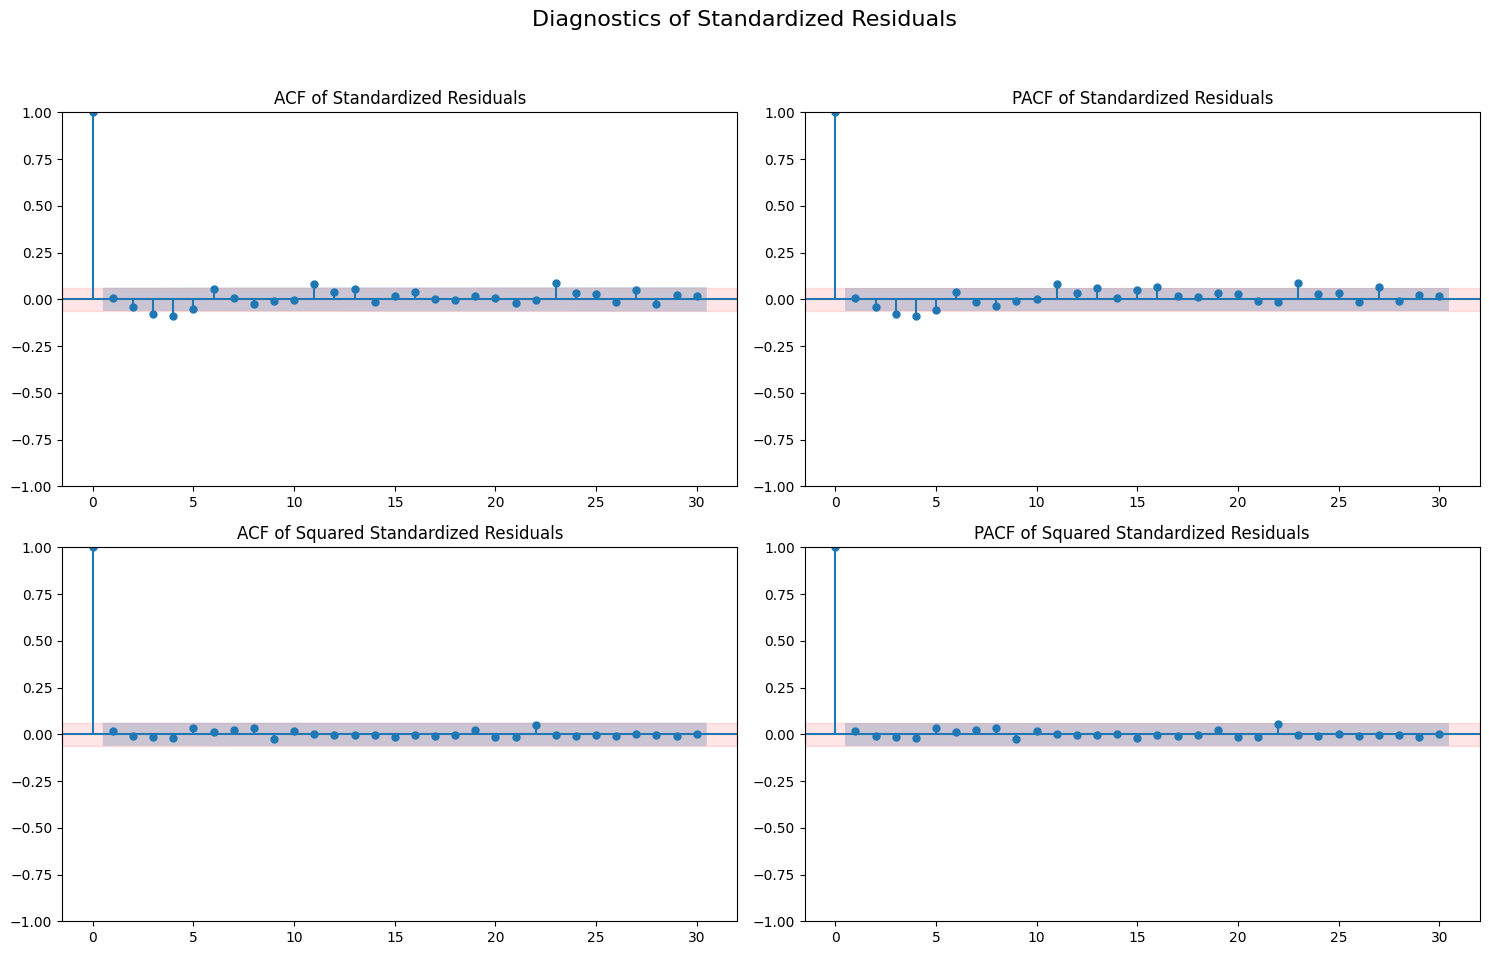

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Diagnostics of Standardized Residuals', fontsize=16)

# Top Row: Check for autocorrelation in the mean (should be flat)
plot_acf(standardized_residuals.dropna(), lags=30, ax=axes[0, 0], title='ACF of Standardized Residuals')
plot_pacf(standardized_residuals.dropna(), lags=30, ax=axes[0, 1], title='PACF of Standardized Residuals')

# Bottom Row: Check for autocorrelation in the variance (should be flat)
plot_acf(std_resid_squared.dropna(), lags=30, ax=axes[1, 0], title='ACF of Squared Standardized Residuals')
plot_pacf(std_resid_squared.dropna(), lags=30, ax=axes[1, 1], title='PACF of Squared Standardized Residuals')

# Add a threshold line (1.96 / sqrt(N) for 95% confidence)
N = len(standardized_residuals.dropna())
threshold = 1.96 / np.sqrt(N)
for i in range(2):
    for j in range(2):
        axes[i, j].axhspan(-threshold, threshold, color='red', alpha=0.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Top row: almost all correlation spikes across both the ACF and PACF are contained within the blue confidence bands -> mean model is highly adequate.

Bottom row: All correlation spikes are contained within the confidence bands- volatility model is highly adequate.

We shall now proceed to backtesting!

## Backtesting

In [73]:
from tqdm import tqdm

In [87]:
# --- CONFIGURATION (UPDATED for High-Fidelity Backtest) ---
# Model Specification
MEAN_MODEL_ORDER = 4
GARCH_P = 1
GARCH_Q = 1

# Backtest Parameters
TRAINING_WINDOW_SIZE = 500 # Use 500 hours of data to fit the model at each step
TRADE_SIZE_USD = 25000     # Notional value for one leg of the trade (e.g., $25k of BTC)
CAPITAL = 100000           # Starting capital in USD
FEE_PER_LEG = 0.001        # 0.1% (Standard Binance Spot Fee)
ENTRY_Z_SCORE = 1.5        # Enter trade when Z-score crosses +/- 2.0
EXIT_Z_SCORE = 0.5         # Exit trade when Z-score crosses +/- 0.5

# Risk-Free Rate
RISK_FREE_RATE_APR = 0.055 # 5.5% Annual RFR (US T-Bill Proxy)
HOURLY_RFR = (1 + RISK_FREE_RATE_APR)**(1/(24*365)) - 1 # ~6.13e-06

In [88]:
# --- DATA PREPARATION (Using your BTC/WBTC data) ---
# Assuming 'btc_wbtc_spread_df' is loaded and contains 'BTC_Price', 'WBTC_Price', and 'Spread'
backtest_df = btc_wbtc_spread_df.copy()

# Backtest columns
backtest_df['Z_Score'] = np.nan
backtest_df['Signal'] = 0
backtest_df['Hourly_PnL'] = 0.0
backtest_df['Fees'] = 0.0
backtest_df['Net_Portfolio_Value'] = CAPITAL


In [89]:
# ----------------------------------------------------------------------
# THE HIGH-FIDELITY BACKTEST LOOP
# ----------------------------------------------------------------------

current_position = 0 # 0=Flat, 1=Long Spread, -1=Short Spread
last_entry_spread = 0.0
portfolio_value = CAPITAL

# The backtest starts after the first full training window is available
start_index = TRAINING_WINDOW_SIZE
end_index = len(backtest_df)

print("--- Starting High-Fidelity Rolling Backtest ---")
print(f"Training Window: {TRAINING_WINDOW_SIZE} hours | Trade Size: ${TRADE_SIZE_USD:,.2f} per leg")

for i in tqdm(range(start_index, end_index)):
    
    # 1. Prepare the training data for this step
    training_data = backtest_df['Spread'].iloc[i - TRAINING_WINDOW_SIZE : i]
    
    # --- MODEL FITTING & FORECASTING (The Core of Accuracy) ---
    try:
        # Re-fit the AR(4)-GARCH(1,1) model on the rolling window
        model = arch_model(
            training_data, 
            mean='AR', lags=MEAN_MODEL_ORDER,
            vol='Garch', p=GARCH_P, q=GARCH_Q,
            dist='t',
            rescale=True # Let the library handle scaling internally
        )
        fit_result = model.fit(disp='off')
        
        # Forecast one step ahead
        forecast = fit_result.forecast(horizon=1)
        mean_forecast = forecast.mean.iloc[-1, 0]
        variance_forecast = forecast.variance.iloc[-1, 0]
        vol_forecast = np.sqrt(variance_forecast)

    except Exception as e:
        # If the model fails to converge on a particular window, hold the position
        # and do not generate a new signal.
        backtest_df.loc[backtest_df.index[i], 'Signal'] = current_position
        # Accrue risk-free rate
        portfolio_value *= (1 + HOURLY_RFR)
        backtest_df.loc[backtest_df.index[i], 'Net_Portfolio_Value'] = portfolio_value
        continue

    # 2. Generate the Signal
    current_spread = backtest_df['Spread'].iloc[i]
    
    # Z-score = (Actual Value - Forecasted Mean) / Forecasted Volatility
    z_score = (current_spread - mean_forecast) / (vol_forecast + 1e-9) # Add epsilon for safety
    backtest_df.loc[backtest_df.index[i], 'Z_Score'] = z_score
    
    # 3. Accrue Risk-Free Rate on the entire portfolio
    rfr_pnl = portfolio_value * HOURLY_RFR
    portfolio_value += rfr_pnl
    backtest_df.loc[backtest_df.index[i], 'Hourly_PnL'] = rfr_pnl

    # 4. Apply Trading Logic
    # Check for EXIT
    if current_position != 0:
        if (current_position == 1 and z_score > -EXIT_Z_SCORE) or \
           (current_position == -1 and z_score < EXIT_Z_SCORE):
            
            # --- EXECUTE EXIT ---
            pnl_unscaled = current_position * (current_spread - last_entry_spread)
            trade_pnl_usd = pnl_unscaled * TRADE_SIZE_USD
            
            # Total fees for a round trip (4 legs)
            total_fees = 4 * FEE_PER_LEG * TRADE_SIZE_USD
            net_trade_pnl = trade_pnl_usd - total_fees
            
            # Update Portfolio
            portfolio_value += net_trade_pnl
            
            # Store results
            backtest_df.loc[backtest_df.index[i], 'Hourly_PnL'] += net_trade_pnl
            backtest_df.loc[backtest_df.index[i], 'Fees'] = total_fees
            
            current_position = 0 # Reset position
            
    # Check for ENTRY
    if current_position == 0:
        if z_score < -ENTRY_Z_SCORE:
            current_position = 1 # Long Spread
            last_entry_spread = current_spread
        elif z_score > ENTRY_Z_SCORE:
            current_position = -1 # Short Spread
            last_entry_spread = current_spread
            
    backtest_df.loc[backtest_df.index[i], 'Signal'] = current_position
    backtest_df.loc[backtest_df.index[i], 'Net_Portfolio_Value'] = portfolio_value


print("\n--- Backtest Complete ---")

--- Starting High-Fidelity Rolling Backtest ---
Training Window: 500 hours | Trade Size: $25,000.00 per leg


100%|██████████| 500/500 [00:09<00:00, 53.07it/s]


--- Backtest Complete ---


In [90]:
# --- PERFORMANCE ANALYSIS ---
results = backtest_df.iloc[start_index:]
total_return = (results['Net_Portfolio_Value'].iloc[-1] / results['Net_Portfolio_Value'].iloc[0]) - 1
sharpe_ratio = (results['Net_Portfolio_Value'].pct_change().mean() * np.sqrt(24 * 365)) / (results['Net_Portfolio_Value'].pct_change().std() + 1e-9)

print(f"Final Equity: ${portfolio_value:,.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")


Final Equity: $100,209.42
Total Return: 0.21%
Annualized Sharpe Ratio: 9.07


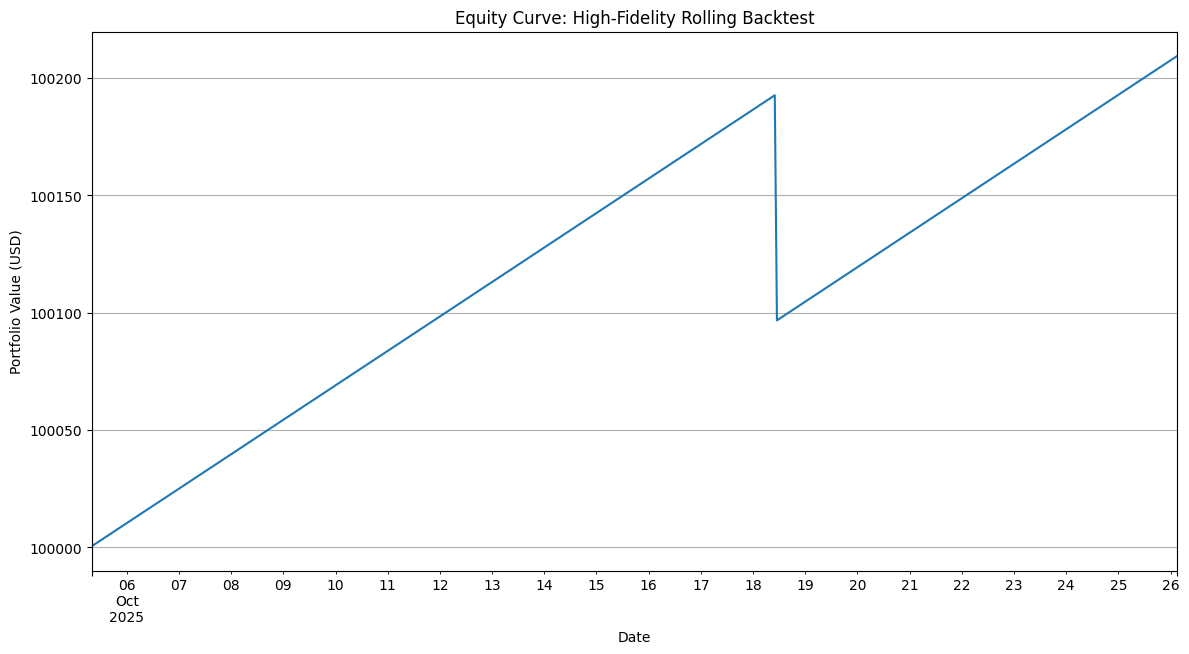

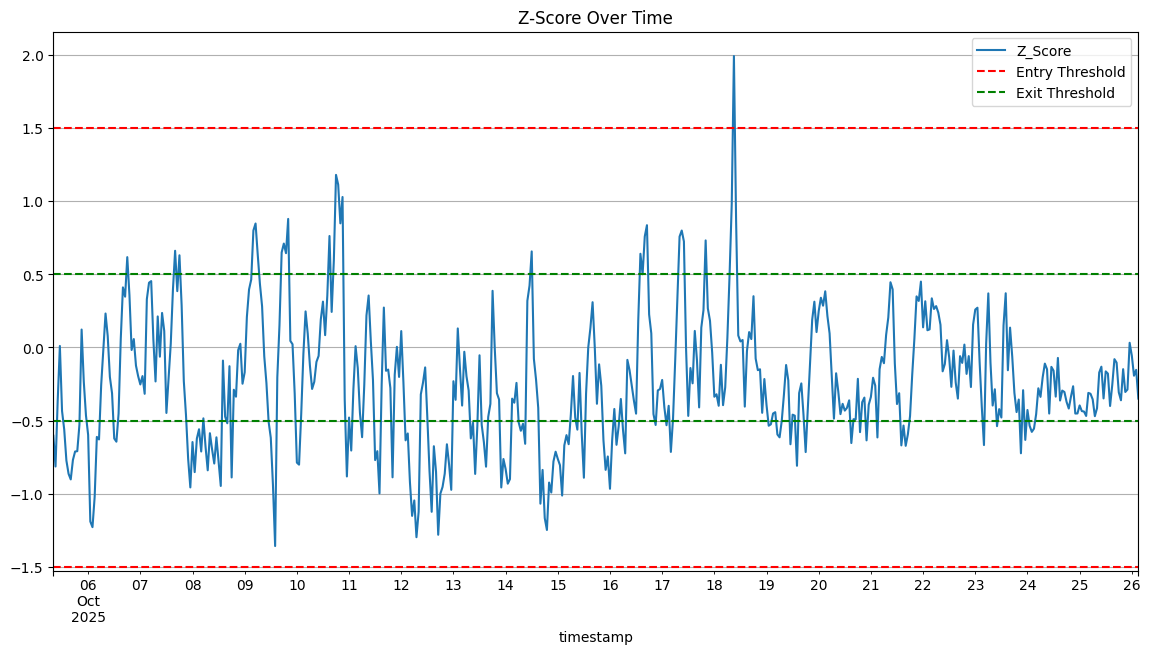

In [91]:
# --- PLOTTING RESULTS ---
plt.figure(figsize=(14, 7))
results['Net_Portfolio_Value'].plot(title='Equity Curve: High-Fidelity Rolling Backtest', grid=True)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.show()

plt.figure(figsize=(14, 7))
results['Z_Score'].plot(title='Z-Score Over Time', grid=True)
plt.axhline(ENTRY_Z_SCORE, color='r', linestyle='--', label='Entry Threshold')
plt.axhline(-ENTRY_Z_SCORE, color='r', linestyle='--')
plt.axhline(EXIT_Z_SCORE, color='g', linestyle='--', label='Exit Threshold')
plt.axhline(-EXIT_Z_SCORE, color='g', linestyle='--')
plt.legend()
plt.show()

In [92]:
# --- Trade-by-Trade Performance Analysis ---
# This block assumes 'backtest_df', 'start_index', 'CAPITAL', and 'HOURLY_RFR' 
# from your backtest script are available.

print("\n--- Trade-by-Trade Performance Analysis ---")
print("These metrics provide a more realistic view than the Sharpe Ratio for HFT strategies.")

# 1. Identify all rows where a trade was closed.
# The cleanest way to do this is to find rows where fees were charged.
closing_trades_df = backtest_df[backtest_df['Fees'] > 0].copy()

if closing_trades_df.empty:
    print("\nNo trades were executed in the backtest.")
else:
    # 2. Isolate the PnL from the trade itself.
    # The 'Hourly_PnL' on a closing row contains both the trade's PnL and one hour of RFR.
    # We must subtract the RFR component to get the pure trade PnL.
    
    # Get the portfolio value just BEFORE the trade PnL was added.
    closing_indices = closing_trades_df.index
    prev_indices = backtest_df.index.get_indexer(closing_indices) - 1
    portfolio_value_before_trade = backtest_df['Net_Portfolio_Value'].iloc[prev_indices].values

    # Calculate pure trade PnL
    rfr_pnl_component = portfolio_value_before_trade * HOURLY_RFR
    closing_trades_df['Trade_PnL'] = closing_trades_df['Hourly_PnL'] - rfr_pnl_component
    
    trade_pnl_list = closing_trades_df['Trade_PnL'].tolist()

    # 3. Calculate Key Metrics
    total_trades = len(trade_pnl_list)
    
    winning_trades = [pnl for pnl in trade_pnl_list if pnl > 0]
    losing_trades = [pnl for pnl in trade_pnl_list if pnl <= 0]
    
    num_winning_trades = len(winning_trades)
    num_losing_trades = len(losing_trades)
    
    # --- CORE METRICS ---
    win_rate = (num_winning_trades / total_trades) * 100 if total_trades > 0 else 0
    average_profit_per_trade = np.mean(trade_pnl_list) if total_trades > 0 else 0
    
    # --- ADDITIONAL USEFUL METRICS ---
    average_winning_trade = np.mean(winning_trades) if num_winning_trades > 0 else 0
    average_losing_trade = np.mean(losing_trades) if num_losing_trades > 0 else 0
    
    # Profit Factor: Gross profits divided by gross losses. A value > 1 is profitable.
    total_profit = np.sum(winning_trades)
    total_loss = abs(np.sum(losing_trades))
    profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')

    # 4. Print the Results
    print("\n" + "="*40)
    print("      Strategy Performance Metrics")
    print("="*40)
    print(f"Total Completed Trades:   {total_trades}")
    print(f"Win Rate:                 {win_rate:.2f}%")
    print("-" * 40)
    print(f"Average Profit per Trade: ${average_profit_per_trade:,.2f}")
    print(f"Average Winning Trade:    ${average_winning_trade:,.2f}")
    print(f"Average Losing Trade:     (${abs(average_losing_trade):,.2f})")
    print("-" * 40)
    print(f"Total Profit from Wins:   ${total_profit:,.2f}")
    print(f"Total Loss from Losses:   (${total_loss:,.2f})")
    print(f"Profit Factor:            {profit_factor:.2f}")
    print("="*40)


--- Trade-by-Trade Performance Analysis ---
These metrics provide a more realistic view than the Sharpe Ratio for HFT strategies.

      Strategy Performance Metrics
Total Completed Trades:   1
Win Rate:                 0.00%
----------------------------------------
Average Profit per Trade: $-96.54
Average Winning Trade:    $0.00
Average Losing Trade:     ($96.54)
----------------------------------------
Total Profit from Wins:   $0.00
Total Loss from Losses:   ($96.54)
Profit Factor:            0.00


Initially I've set the Z-score entry at 2.0, but that was too strict. I've changed it to 1.25 and there were 4 entries, but it was a losing strategy. I've updated it to 1.5, and it was still an unprofitable strategy with only 1 trade in around 1.5 month worth of backtest data.

This confirms that even minor statistical deviations are extremely rare for BTC/WBTC pair. The opportunity frequency is practically zero. The market for this pair is extremely efficient.

A natural next step may be to move to a new pair. In my case, I will continue with learning about other strategies to build up my toolbox first.